## Verifying Calendar Loss

In [1]:
import numpy as np

f, Ea, R, T, t = 14876, 24500, 8.314, 300, 3
conti_qloss = f * np.exp( -Ea/(R*T) ) * pow(t,0.5) 
del_t = 1/24 # day
dis_qloss = 0.5 * f * np.exp( -Ea/(R*T) ) * pow(t,0.5) * del_t

step = int(t/del_t);
loss2 = [0]
t = 1/24
for i in range(step):
    # del_t = 1
    t += del_t # day(incremental time)
    # loss2 += f * np.exp( -Ea/(R*T) ) * pow(t,0.5) 
    loss2.append(f * np.exp( -Ea/(R*T) ) * pow(t,0.5))

print("coninuos_loss =",conti_qloss,"%")
print("discrete_loss =",loss2[-1],"%")
print("error =", abs(conti_qloss - loss2[-1]),"%")

coninuos_loss = 1.3965734896697573 %
discrete_loss = 1.4062384734319229 %
error = 0.009664983762165624 %


# Part 1 project 2020-21

## **Import necessery libraries**

In [3]:
import decimal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files # to download the files
import matplotlib
import warnings
warnings.filterwarnings(action='once')
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [4]:
# # For printing whole dataframe
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

/home/hiren/jpyter_dir/jpyter_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
matplotlib.rcParams ;

In [6]:
matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['figure.facecolor'] = 'white'

## Defining important functions


### Degradation functions

In [7]:
def cycle_deg(cycle_const, T, b_current, c_rate, del_t):
    a,b,c,d,e = cycle_const[0], cycle_const[1], cycle_const[2], cycle_const[3], cycle_const[4]
    cells_per_mod = 72

    B1 = a*pow(T,2) + b*T + c
    B2 = d*T + e
    cell_current = b_current / cells_per_mod
    cycle_loss = B1 * np.exp(B2 * c_rate) * cell_current * (del_t/60) # del_t in hour
    # cycle_loss = B1 * np.exp(B2 * c_rate) * cell_current * (del_t/60) # del_t in hour
    return cycle_loss

def cal_deg(cal_const, T, t, del_t):
    f,Ea,R = cal_const[0], cal_const[1], cal_const[2]
    cal_deg = f * np.exp(-Ea/(R*T)) * pow(del_t,0.5)
    # cal_deg = 0.5 * f * np.exp(-Ea/(R*T)) * pow(t,-0.5) * (del_t/(60*24)) # del_t in days
    return cal_deg

def hour2min2hour(hour1, hour2):
    """
    hour1 = arrival time,
    hour2 = departure time
    """
    frac_hour1 = hour1 - int(hour1)
    frac_hour2 = hour2 - int(hour2)
    min = ( (int(hour2) - int(hour1))*60 + (frac_hour2 - frac_hour1)*100 ) / 60
    return min

def hour2steps(hour,step_size):
    """
    -> Convert hour into minute.Unit of step_size in minutes
    -> Divide minutes with step size and u will get steps.
    """
    steps = int(hour * 60 / step_size)
    return steps

def myplot(xvals,yvals, kind='plot', labels=None,xlab=None,ylab=None,titles=None,colors='b',image_name = 'imag.png',save=False):
    plt.rc('xtick',labelsize = 15)
    plt.rc('ytick',labelsize = 15)
    if kind.lower() == 'bar': 
        plt.bar(xvals,yvals,label = labels, linewidth = 2, color = colors)
    else:
        plt.plot(xvals,yvals,label = labels, linewidth = 2, color = colors)
    plt.xlabel(xlab,fontsize = 16)
    plt.ylabel(ylab,fontsize = 16)
    plt.title(titles,fontsize = 18,color = 'black',fontweight = 'bold')
    name = image_name
    if save:
        plt.legend()
        plt.grid()
        plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
        files.download(name) 
    plt.legend()
    plt.grid()
    plt.show()

def print_deg_results(disch_power, disch_time, energy, c_rate, total_deg):
    print(f" disch_power = {disch_power:3f} kW \n disch_time = {disch_time:3f} h \n disch_energy = {energy:3f} kWh \n disc_rate = {c_rate:3f} \n total_deg = {total_deg:5f} %")

## Mounting Google Drive

Blocks_total dataframe

In [9]:
## Converting into DateTime Object

power_df = pd.read_csv('block_totals.csv')
power_df['Time'] = pd.to_datetime(power_df['Time'])
power_df = power_df[:-115] # Removing 30 Sept 2020 data
print("df.shape =",power_df.shape)
print("total data points needs to be =",12*24*366)
print("missing data = ",12*24*366 - len(power_df))
print(f"{(12*24*366 - len(power_df))/(12*24*366) * 100:.3f}% data is missing")

# Removing error from data source, it was showing 644532.57 kW
power_df.power_kW[86018] = (power_df.power_kW[86017] + power_df.power_kW[86019])/2

df.shape = (99232, 2)
total data points needs to be = 105408
missing data =  6176
5.859% data is missing


Ambient Temperature and SOC dataframe

In [12]:
vehicle_df = pd.read_csv('car_data.csv')
vehicle_df.head()

/home/hiren/jpyter_dir/jpyter_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,arr_time,dep_time,soc_initial,soc_final,temp,temp_max,temp_min,Distance travelled,Distance need to travel
0,10,17,0.689,0.481,20.225,29.93,10.52,14,20
1,9,16,0.705,0.426,21.730,31.00,12.46,20,17
2,11,15,0.754,0.386,21.725,30.92,12.53,18,15
3,12,17,0.736,0.464,21.565,31.05,12.08,19,16
4,11,17,0.689,0.442,21.885,31.29,12.48,18,19


In [13]:
# temp = 273 + vehicle_df.temp.values 
temp = 273 + vehicle_df.temp.values 
soc_initial = vehicle_df.soc_initial.values
soc_final = vehicle_df.soc_final.values
int_arr_time = vehicle_df.arr_time.values
int_dep_time = vehicle_df.dep_time.values

# Formation arr_time and dep_time in string format
arr_time = [str(i)+":00:00" for i in int_arr_time]
dep_time = [str(i)+":00:00" for i in int_dep_time]

/home/hiren/jpyter_dir/jpyter_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Graph of SOC Profile

ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of ticklabels (12).

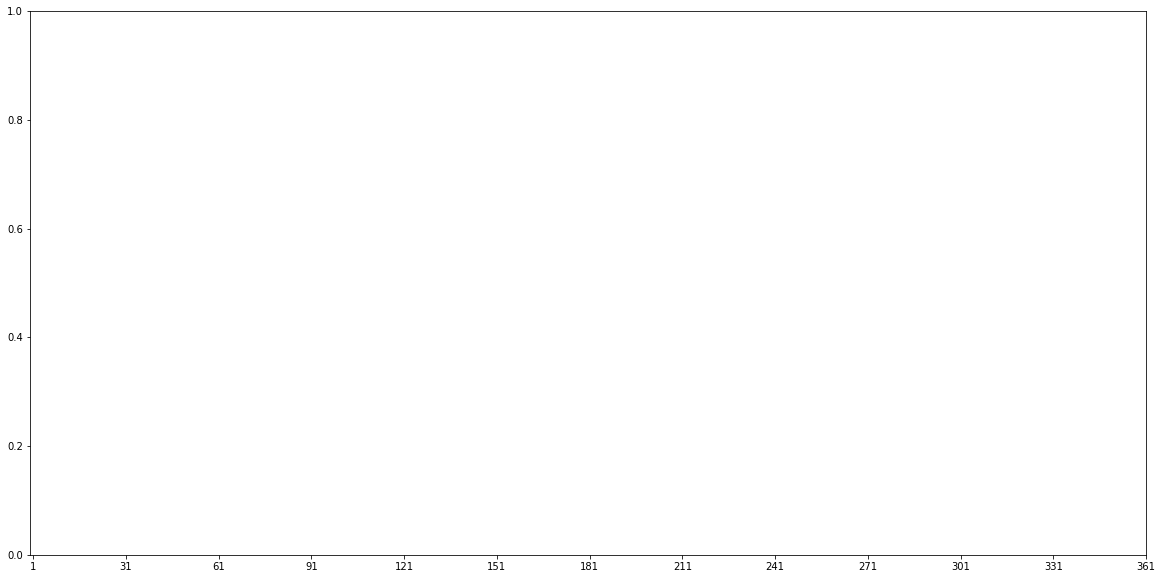

In [16]:
days = list(range(1,len(vehicle_df)+1))
plt.xticks(np.arange(1,365,30), 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split())
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.bar(days, soc_initial*100, alpha = 0.6, color = 'red', label = 'soc_arrival')
plt.bar(days, soc_final*100, alpha = 0.6, color = 'blue', label = 'soc-departure')
plt.ylabel('SOC(%)', fontsize = 15)
plt.title('Annual SOC profile', fontweight = 'bold', fontsize = 18)
plt.legend()
# plt.savefig("annual_soc.png",bbox_inches = "tight")
# files.download("annual_soc.png") 
plt.show()

No handles with labels found to put in legend.


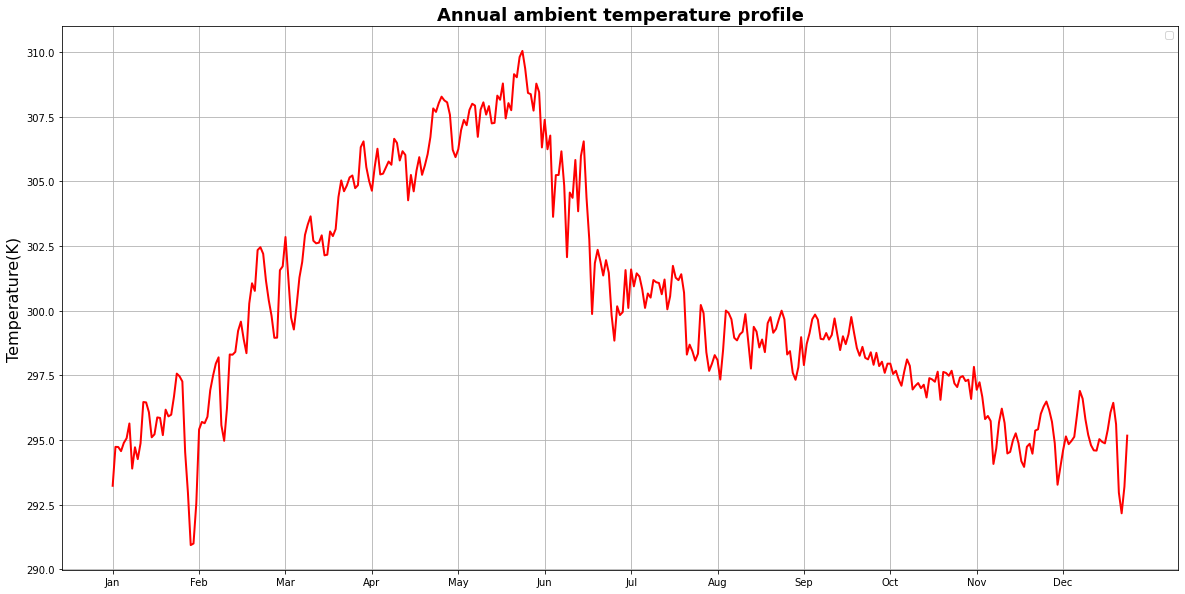

In [17]:
plt.xticks(np.arange(1,365,31), 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split())
xvals = days
yvals = temp
ylab = 'Temperature(K)';  title = "Annual ambient temperature profile"; 

myplot(days, temp, ylab=ylab, titles=title, colors = 'red', image_name='annual_temp.png', save=False)

## Data Preprocessing

#### Data from 30-09-2019 to 29-09-2020 (366 days)
2020 was a leap year.

### Playing with Dataframe

In [18]:
power_df.dtypes 

/home/hiren/jpyter_dir/jpyter_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time        datetime64[ns]
power_kW           float64
dtype: object

### Handling missing timestamp

if Timestamp is not index of dataframe

In [19]:
min = 5
power_df = power_df.resample(str(60 * min) + 'S', on = 'Time', base = 0).mean();
power_df = power_df.reset_index()
power_df.head()

<ipython-input-19-e7c2bca6e5c5>:2: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  power_df = power_df.resample(str(60 * min) + 'S', on = 'Time', base = 0).mean();


,Time,power_kW
0,2019-09-30 00:00:00,272.8954
1,2019-09-30 00:05:00,273.5255
2,2019-09-30 00:10:00,274.5477
3,2019-09-30 00:15:00,275.4971
4,2019-09-30 00:20:00,274.5478


### Interpolating missing values

In [20]:
power_df.interpolate(method = 'linear', inplace = True)
print("power_df.shape = " + str(power_df.shape))

# Checking for Null values
power_df.isnull().sum()

power_df.shape = (105408, 2)


/home/hiren/jpyter_dir/jpyter_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time        0
power_kW    0
dtype: int64

In [21]:
power_df['year'] = power_df['Time'].dt.year
power_df['month'] = power_df['Time'].dt.month
# power_df['day of week'] = power_df['Time'].dt.dayofweek
day_map = {
    0: 'Sun',
    1: 'Mon',
    2: 'Tue',
    3: 'Wed',
    4: 'Thu',
    5: 'Fri',
    6: 'Sat',
}

# power_df['day_name'] = power_df['Time'].dt.weekday.map(day_map)
power_df.head(), power_df.shape

(                 Time  power_kW  year  month
 0 2019-09-30 00:00:00  272.8954  2019      9
 1 2019-09-30 00:05:00  273.5255  2019      9
 2 2019-09-30 00:10:00  274.5477  2019      9
 3 2019-09-30 00:15:00  275.4971  2019      9
 4 2019-09-30 00:20:00  274.5478  2019      9,
 (105408, 4))

In [22]:
power_df.power_kW[15701] = (power_df.power_kW[15700] + power_df.power_kW[15702])/2
power_df.power_kW[81976] = (power_df.power_kW[81975] + power_df.power_kW[81977])/2
power_df.power_kW[86018] = (power_df.power_kW[86017] + power_df.power_kW[86019])/2
power_df.power_kW[98901] = (power_df.power_kW[98900] + power_df.power_kW[98902])/2

/home/hiren/jpyter_dir/jpyter_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-22-5d03eed69984>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df.power_kW[15701] = (power_df.power_kW[15700] + power_df.power_kW[15702])/2


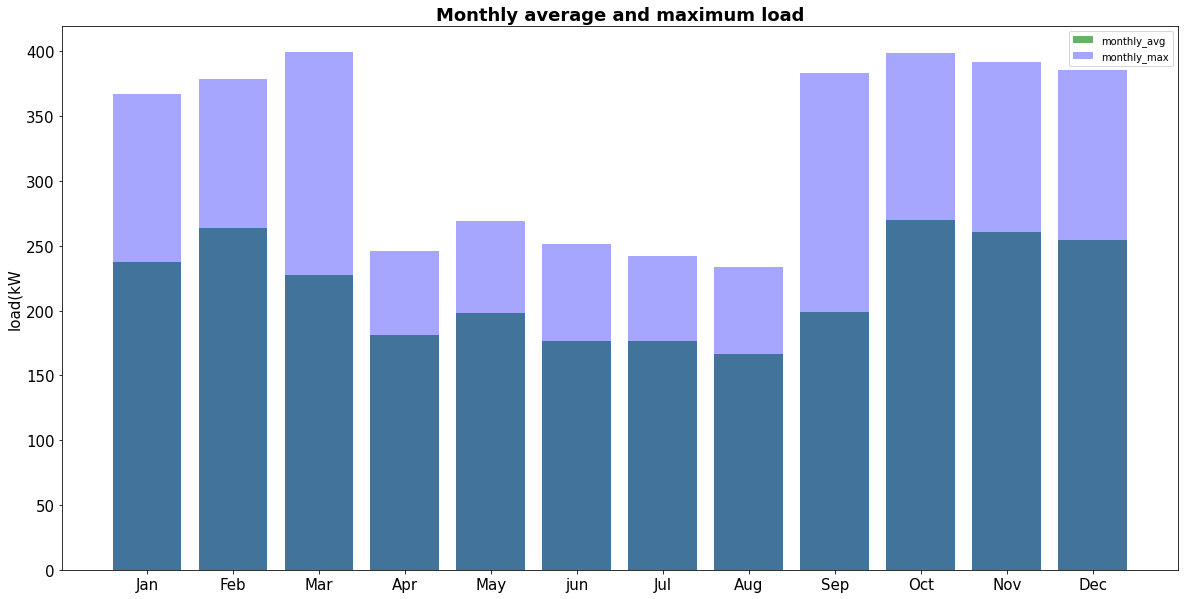

In [23]:
infos = power_df.groupby(power_df.month).describe()
idx = pd.IndexSlice
monthly_max = infos.loc[:,idx[:,'max']].power_kW
monthly_avg = infos.loc[:,idx[:,'mean']].power_kW

monthly_max = [366.812 ,
       378.6985,
       399.4743,
       246.2416,
       269.3244,
       251.4524,
       241.8515,
       233.7269,
       383.3913,
       398.7207,
       391.8083,
       385.2962]

monthly_avg = [237.86416412,
       263.70647434,
       227.31977774,
       181.52795604,
       198.39928672,
       176.91045475,
       176.59390655,
       166.22365509,
       198.78110799,
       269.64182736,
       260.41158466,
       254.18240651]

# plt.bar(months, monthly_avg)
months = list(range(1,13))
plt.xticks(np.arange(1,13), np.arange(1,13))
plt.xticks(np.arange(1,13), 'Jan Feb Mar Apr May jun Jul Aug Sep Oct Nov Dec'.split())
# plt.xtciks()
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)

plt.bar(months, monthly_avg, alpha = 0.6, color = 'green', label = 'monthly_avg')
plt.bar(months, monthly_max, alpha = 0.35, color = 'blue', label = 'monthly_max')
# plt.xlabel('months', fontsize = 15)
plt.ylabel('load(kW', fontsize = 15)
plt.title('Monthly average and maximum load', fontweight = 'bold', fontsize = 18)
plt.legend()
# plt.savefig("monthly_stats.png",bbox_inches = "tight")
# files.download("monthly_stats.png") 
plt.show()

## **Data Analysis from 17-09-2020 to 23-09-2020**

### Data of 17-09-2020

In [24]:
start_index = power_df[power_df.Time == '2020-09-17 00:00:00'].index.values[0]
tmp_df = power_df[start_index:start_index + 288*7][:288] # for 1 day
print("vehicle_df.shape =",vehicle_df.shape)
tmp_df.head()

vehicle_df.shape = (365, 9)


,Time,power_kW,year,month
101664,2020-09-17 00:00:00,181.3058,2020,9
101665,2020-09-17 00:05:00,184.7308,2020,9
101666,2020-09-17 00:10:00,175.0455,2020,9
101667,2020-09-17 00:15:00,173.8043,2020,9
101668,2020-09-17 00:20:00,172.9643,2020,9


## Data Visulization

ValueError: The number of FixedLocator locations (26), usually from a call to set_ticks, does not match the number of ticklabels (25).

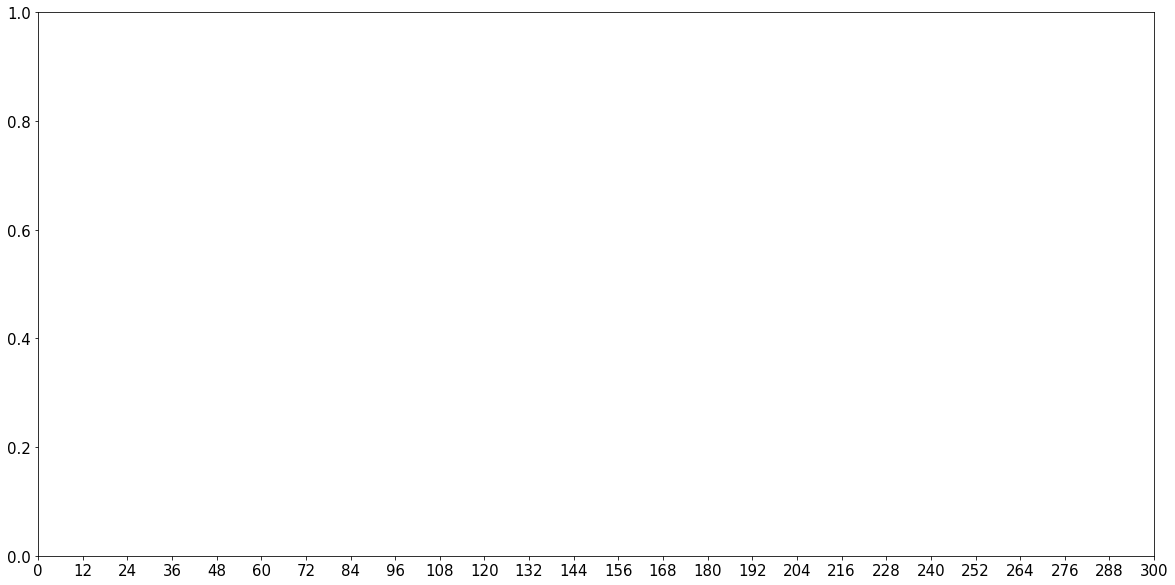

In [26]:
time_step = np.arange(1,1+len(tmp_df))
power = tmp_df.power_kW.values

xlab = 'time(h)'
ylab = 'power(kW)'
xvals = time_step
yvals = power
title = "17th Sept 2020 load profile of A block"
# myplot(xvals, yvals, xlab, ylab,title)

plt.figure(figsize = (20,10), facecolor = 'white')
# plt.xticks(np.linspace(0,len(power_df),), list(range(0,int(24*60/stepsize),5)))
plt.xticks(np.arange(0,24*(12+1),12), np.arange(0,24+1))
# xlab = 'Jan Feb Mar Apr May June July Aug Sep oct Nov Dec'.split() 
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)

plt.bar(xvals, yvals, color='b',label = 'daily_load')
# plt.plot(xvals, yvals2, 'r--',label = 'range_max_load')
# plt.plot(xvals, yvals3, 'r--')
plt.xlabel(xlab, fontsize = 15)
plt.ylabel(ylab, fontsize = 15)
plt.title(title, fontsize = 18, fontweight = 'bold')
plt.legend()
plt.grid()
plt.show()

### Uncoordinated power conversion
* Here vehicle will discharge in building as soon as it arrives.So perform calculations based on this thing only.

## Degradation Program for 365 days + 1 Car 
### Uncoordinated power conversion
* Here vehicle will discharge in building as soon as it arrives.




### Assumptions
1. Power is constant throughout the period.
2. Temperature is constant throughout the period. 
3. Battery voltage is constant throughout the period.
4. Arrival and departure time duration is considered instead of whole day.
5. Power consumed during driving and its dependency on driving pattern is ignored.

\begin{equation*}
P_{DC} = \frac {P_{AC}}{\eta} \\
C-rate = \frac {Charger \space power(kW)} {Battery \space Capacity (kWh)} \\
C-rate = \frac {P_{AC}} {\eta \cdot Battery \space Capacity (kWh) } \\
\end{equation*}

### Degradation constants

In [27]:
cal_const = [14786, 24500, 8.314] # [f, Ea, R]
cycle_const = [8.6772e-6, -5.1613e-3, 7.6788e-1, -6.7e-3, 2.35] #[a, b, c, d, e]

Considering degradation during parking in building: \\
**Here I am only cosidering degradation due to cycles but you also need to include calendar degrdation in calculation.**

In [28]:
import numpy as np

f, Ea, R, T, t = 14876, 24500, 8.314, 300, 3
conti_qloss = f * np.exp( -Ea/(R*T) ) * pow(t,0.5) 
del_t = 1/24 # day
dis_qloss = 0.5 * f * np.exp( -Ea/(R*T) ) * pow(t,0.5) * del_t

step = int(t/del_t)
loss2 = [0]
t = 1/24
for i in range(step):
    # del_t = 1
    t += del_t # day(incremental time)
    loss2.append( f * np.exp( -Ea/(R*T) ) * pow(t,0.5) )

print("coninuos_loss =",conti_qloss,"%")
print("discrete_loss =",loss2[-1],"%")
print("error =", abs(conti_qloss - loss2[-1]),"%")

coninuos_loss = 1.3965734896697573 %
discrete_loss = 1.4062384734319229 %
error = 0.009664983762165624 %


In [29]:
import numpy as np

f, Ea, R, T, t = 14786, 24500, 8.314, 300, 1
conti_qloss = f * np.exp( -Ea/(R*T) ) * pow(t,0.5) 
del_t = 1/24 # day

step = int(t/del_t)
loss2 = [0]
t2 = 1/24
deg=0
for i in range(step):
    # del_t = 1
    # t2 += del_t # day(incremental time)
    deg += f * np.exp( -Ea/(R*T) ) * pow(t,0.5) * del_t
    loss2.append(deg)

print("discrete_loss =",loss2[-1],"%")
print("coninuos_loss =",conti_qloss,"%")
print("error =", abs(conti_qloss - loss2[-1]),"%")

discrete_loss = 0.8014338812782534 %
coninuos_loss = 0.8014338812782535 %
error = 1.1102230246251565e-16 %


In [30]:
def cycle_deg(cycle_const, T, b_current, c_rate, del_t):
    a,b,c,d,e = cycle_const[0], cycle_const[1], cycle_const[2], cycle_const[3], cycle_const[4]
    cells_per_mod = 72

    B1 = a*pow(T,2) + b*T + c
    B2 = d*T + e
    cell_current = b_current / cells_per_mod
    cycle_loss = B1 * np.exp(B2 * c_rate) * cell_current * (del_t/60) # del_t in hour
    # cycle_loss = B1 * np.exp(B2 * c_rate) * cell_current * (del_t/60) # del_t in hour
    return cycle_loss

def cal_deg(cal_const, T, t):
    f,Ea,R = cal_const[0], cal_const[1], cal_const[2]
    # t = t/24 # Convert it into day
    cal_deg = f * np.exp(-Ea/(R*T)) * pow(t/24,0.5)
    # cal_deg = 0.5 * f * np.exp(-Ea/(R*T)) * pow(t,-0.5) * (del_t/(60*24)) # del_t in days
    return cal_deg

def hour2min2hour(hour1, hour2):
    """
    hour1 = arrival time,
    hour2 = departure time
    """
    frac_hour1 = hour1 - int(hour1)
    frac_hour2 = hour2 - int(hour2)
    min = ( (int(hour2) - int(hour1))*60 + (frac_hour2 - frac_hour1)*100 ) / 60
    return min

def hour2steps(hour,step_size):
    """
    -> Convert hour into minute.Unit of step_size in minutes
    -> Divide minutes with step size and u will get steps.
    """
    steps = int(hour * 60 / step_size)
    return steps

def myTemp(ambient_temp, power):
    rth = 2 # Celcius / kW
    return ambient_temp + rth * power

def myplot(xvals,yvals, kind='plot', labels=None,xlab=None,ylab=None,titles=None,colors='b',image_name = 'imag.png',save=False):
    plt.rc('xtick',labelsize = 15)
    plt.rc('ytick',labelsize = 15)
    if kind.lower() == 'bar': 
        plt.bar(xvals,yvals,label = labels, linewidth = 2, color = colors)
    else:
        plt.plot(xvals,yvals,label = labels, linewidth = 2, color = colors)
    plt.xlabel(xlab,fontsize = 16)
    plt.ylabel(ylab,fontsize = 16)
    plt.title(titles,fontsize = 18,color = 'black',fontweight = 'bold')
    name = image_name
    if save:
        plt.legend()
        plt.grid()
        plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
        files.download(name) 
    plt.legend()
    plt.grid()
    plt.show()

def print_deg_results(disch_power, disch_time, energy, c_rate, total_deg):
    print(f" disch_power = {disch_power:3f} kW \n disch_time = {disch_time:3f} h \n disch_energy = {energy:3f} kWh \n disc_rate = {c_rate:3f} \n total_deg = {total_deg:5f} %")

In [35]:
## Home to building and building to home
drive_energy = 0.15 # kWh / km
distance = 30
travel_time = 45/60 # hour
travel_steps = int(travel_time/step * 60)
travel_energy = drive_energy * distance

eff_b2w = 0.7 # efficiency of battery to wheel
bty_tvl_pwr = travel_energy / (travel_time * eff_b2w) # Power from battery after travelling
travel_c_rate = bty_tvl_pwr / b_cap

# At home
home_charger = 10 # kW
rth = 2 # Celcius/kW

# Calculate degradation during travel time
np.random.seed(1)
int_arr_time = np.random.randint( 9,11, size = (len(vehicle_df),1) )
int_dep_time = np.random.randint( 16,18, size = (len(vehicle_df),1) )

# total_deg = 0

cum_daily_deg = [0]
# for i in range(len(vehicle_df)):  ## Let's try accumulated degradation
for i in range(30):
        total_deg = 0
        
        #### Degradation during travelling from and to the building (Cycle)
        b_cap_kwh = b_percent_cap[i] * b_cap / 100
        travel_time = 45/60 # hour
        travel_energy = 0.1 * b_cap_kwh  # 10% energy is lost in travel time
        bty_tvl_pwr = travel_energy / (travel_time * eff_b2w) # Power from battery after travelling
        travel_temp = myTemp(temp[i], bty_tvl_pwr)
        b_current = bty_tvl_pwr / b_volt
        c_rate = bty_tvl_pwr / b_cap_kwh
        for j in range(travel_steps):
            total_deg += cycle_deg(cycle_const, travel_temp, b_current, c_rate, del_t)
        total_deg *= 2 # Multiply by 2 because of same degradation during from and to the building

        # print("total deg travel :",total_deg)

        #### Degradation in the building(Calendar + Cycle)
        disch_energy = 0.6 * b_cap_kwh # 60% of total energy
        standing_time = int_dep_time[i] - int_arr_time[i]
        cycle_time = 3 # car will discharge in 3h(Cycle) and remaining time it will stand(Calendar)
        cal_time = standing_time - cycle_time
        cycle_steps = int(cycle_time * 60/step)
        cal_steps = int(cal_time * 60/step)

        # I am considerig battery capacity at the start of the day.

        # Cycle degradation during discharge into building
        disch_power = disch_energy / ( cycle_time * charger_eff )
        b_current = disch_power / b_volt
        c_rate = disch_power / b_cap_kwh
        cycle_temp = myTemp(temp[i], disch_power)
        for j in range(cycle_steps):
            total_deg += cycle_deg(cycle_const, cycle_temp, b_current, c_rate, del_t)
        
        # Calendar degradation during standing into building parking lot
        # for j in range(cal_steps):
        total_deg += cal_deg(cal_const, temp[i], cal_time)

        print(f"total deg = {total_deg}, cal_steps = {cal_steps}")
        #### Degradation at home(Cycle + Calendar)
        pump_energy = 0.8 * b_cap_kwh # (2*travel_energy + discharge energy into building)
        cycle_time = 3
        charge_power = charger_eff * pump_energy / cycle_time
        b_current = charge_power / b_volt
        cal_time = 24 - 2*travel_time - standing_time
        cycle_steps = int(cycle_time * 60/step)
        cal_steps = int(cal_time * 60/step)

        # Cycle degradation during charge through grid
        disch_power = disch_energy / cycle_time
        b_current = (disch_power / (b_cap_kwh * charger_eff))
        c_rate = disch_power / b_cap_kwh
        cycle_temp = myTemp(temp[i], disch_power)
        for j in range(cycle_steps):
            total_deg += cycle_deg(cycle_const, cycle_temp, b_current, c_rate, del_t)
        
        # Calendar degradation during standing at home
        # for j in range(cal_steps):
        total_deg += cal_deg(cal_const, temp[i], cal_time)

        b_percent_cap.append(b_percent_cap[i] - total_deg)
        cum_daily_deg.append(total_deg)
cum_daily_deg = np.cumsum(np.array(cum_daily_deg))
print(f"total deg after {i+1}  day : {cum_daily_deg[-1]}")


        
        
        
            
            












        
        # b_cap_kwh = b_percent_cap[i] * b_cap / 100
        # in_time = int_arr_time[i]
        # out_time = int_dep_time[i]
        # energy = (soc_initial[i] - soc_final[i]) * b_cap_kwh # kWh
        # total_energy.append(energy)
        # disch_time = hour2min2hour(in_time, out_time)
        # disch_power = energy/disch_time # kW
        # disch_temp = temp + rth * disch_power ###################################
        # c_rate = disch_power / (charger_eff * b_cap_kwh) #0.1358
        # b_current = disch_power*1000 / b_volt # Ampere

        # # Degradation due to discharging
        # disch_deg = 0
        # disch_duration = hour2steps(disch_time, step)
        # for j in range(disch_duration):
        #     disch_deg += cycle_deg(cycle_const, disch_temp[i], b_current, c_rate, del_t)
        
        # charge_power = home_power # kW
        # charge_temp = temp + rth * charge_power #################################
        # charge_c_rate = charge_power / b_cap_kwh
        # charge_time = energy / charge_power # hour
        # charge_battery_current = charge_power*1000 / b_volt # Ampere
        
        # # Degradation due to charging
        # ch_deg = 0
        # charge_duration = hour2steps(charge_time, step)
        # for k in range(charge_duration):
        #     ch_deg += cycle_deg(cycle_const, charge_temp[i], charge_battery_current, charge_c_rate, del_t)
        
        # stand_time_vec.append(24 - travel_time - charge_time - disch_time)
        # daily_deg.append(ch_deg + disch_deg)
        # b_percent_cap.append(b_percent_cap[i] - daily_deg[i+1])

total deg = [0.22581934], cal_steps = 36
total deg = [0.23771072], cal_steps = 36
total deg = [0.27443771], cal_steps = 48
total deg = [0.27295125], cal_steps = 48
total deg = [0.23896333], cal_steps = 36
total deg = [0.24042459], cal_steps = 36
total deg = [0.28301559], cal_steps = 48
total deg = [0.23101347], cal_steps = 36
total deg = [0.23758978], cal_steps = 36
total deg = [0.27008956], cal_steps = 48
total deg = [0.30834271], cal_steps = 60
total deg = [0.25203551], cal_steps = 36
total deg = [0.32521184], cal_steps = 60
total deg = [0.28719102], cal_steps = 48
total deg = [0.24070955], cal_steps = 36
total deg = [0.27903033], cal_steps = 48
total deg = [0.31893583], cal_steps = 60
total deg = [0.2850732], cal_steps = 48
total deg = [0.27874739], cal_steps = 48
total deg = [0.32216984], cal_steps = 60
total deg = [0.28564955], cal_steps = 48
total deg = [0.28627497], cal_steps = 48
total deg = [0.29312898], cal_steps = 48
total deg = [0.33755391], cal_steps = 60
total deg = [0.30

In [55]:
temp[0]

293.225

###Case 2: Without peak load detection and driving(Calendar + Cycle degradation) 

In [33]:
b_cap = 38.34 #kWh
b_volt = 355.2 #volt
charger_eff = 0.93
step = 5
del_t = step
rth = 2
b_percent_cap = [100]
c_rates = []
travel_time = 3 # hour


def degWithoutDrive(b_cap, b_volt, charger_eff, rth,travel_time=3):
    total_deg = [0]
    stand_time_vec = []
    daily_deg = [0]
    total_energy = []
    for i in range(len(vehicle_df)):
    # for i in range(6):
        b_cap_kwh = b_percent_cap[i] * b_cap / 100
        in_time = int_arr_time[i]
        out_time = int_dep_time[i]
        energy = (soc_initial[i] - soc_final[i]) * b_cap_kwh # kWh
        total_energy.append(energy)
        disch_time = hour2min2hour(in_time, out_time)
        disch_power = energy/disch_time # kW
        disch_temp = temp + rth * disch_power ###################################
        c_rate = disch_power / (charger_eff * b_cap_kwh) #0.1358
        b_current = disch_power*1000 / b_volt # Ampere

        # Degradation due to discharging
        disch_deg = 0
        disch_duration = hour2steps(disch_time, step)
        for j in range(disch_duration):
            disch_deg += cycle_deg(cycle_const, disch_temp[i], b_current, c_rate, del_t)
        
        charge_power = 3.3 # kW
        charge_temp = temp + rth * charge_power #################################
        charge_c_rate = charge_power / b_cap_kwh
        charge_time = energy / charge_power # hour
        charge_battery_current = charge_power*1000 / b_volt # Ampere
        
        # Degradation due to charging
        ch_deg = 0
        charge_duration = hour2steps(charge_time, step)
        for k in range(charge_duration):
            ch_deg += cycle_deg(cycle_const, charge_temp[i], charge_battery_current, charge_c_rate, del_t)
        
        stand_time_vec.append(24 - travel_time - charge_time - disch_time)
        daily_deg.append(ch_deg + disch_deg)
        b_percent_cap.append(b_percent_cap[i] - daily_deg[i+1])

    # daily_deg = np.array(daily_deg)
    # total_energy = np.array(total_energy)
    # total_deg = np.sum(daily_deg) 
    # total_energy_throughput = np.sum(total_energy)
    # print(f"total_energy_throughput = {total_energy_throughput:.3f} kWh")
    # print(f"total_degradation = {total_deg:.3f}%")


degWithoutDrive(b_cap, b_volt, charger_eff, rth,travel_time=3)

In [57]:
# #@title Example form fields
# #@markdown Forms support many types of fields.

# purchase_price_g2b = 7 #@param {type:"slider", min:3, max:8, step:1}
# sell_price_v2b = 6 #@param {type:"slider", min:3, max:8, step:1}
# purchase_price_g2v = 5 #@param {type:"slider", min:3, max:8, step:1}
# new_battery_price = 260000 #@param {type:"slider", min:200000, max:400000, step:50000}
# old_battery_price = 104000 #@param {type:"slider", min:50000, max:300000, step:10000}
# #@markdown ---

# deg_cost = (total_deg / 20 ) * (new_battery_price - old_battery_price)
# building_profit_per_EV = (purchase_price_g2b - sell_price_v2b) * total_energy_throughput
# ev_profit = total_energy_throughput * (sell_price_v2b - purchase_price_g2v) - deg_cost

# print("EV owner profit =", ev_profit)
# print("Building owner profit =",building_profit_per_EV)

In [58]:
# Consider every month of 30 days
months = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
monthly_deg = []
monthly_energy = []
start,end = 0,30
for i in range(len(months)):
    monthly_deg.append(sum(daily_deg[start:end]))
    monthly_energy.append(sum(total_energy[start:end]))
    start += 30
    end += 30

NameError: ignored

In [ ]:
xvals = months
yvals = monthly_deg
xlab = 'Months'
ylab = 'Degradation in %'
title = "Monthly degradation of single EV battery"

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.figure(figsize = (20,10), facecolor = 'white')
    
plt.bar(xvals, yvals, color='blue')
plt.xlabel(xlab, fontsize = 15)
plt.ylabel(ylab, fontsize = 15)
plt.title(title, fontsize = 22, fontweight = 'bold')
plt.grid()
name = 'monthly_deg'
plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
files.download(name + '.png')
files.download(name) 
plt.legend()

Monthly avg temperature graph

In [ ]:
monthly_avg_temp[4], monthly_deg[4]

In [ ]:
monthly_avg_temp = []
start,end = 0,30
for i in range(12):
    monthly_avg_temp.append(np.mean(temp[start:end]))
    start += 30
    end += 30


xvals = months
yvals = monthly_avg_temp
xlab = 'Months'
ylab = 'Temperature{K}'
title = "Monthly average temperature profile of battery"

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.figure(figsize = (20,10), facecolor = 'white')
    
plt.bar(xvals, yvals, color='b')
plt.xlabel(xlab, fontsize = 15)
plt.ylabel(ylab, fontsize = 15)
plt.title(title, fontsize = 22, fontweight = 'bold')
plt.grid()
name = 'monthly_temp_battery'
plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
files.download(name + '.png')
plt.legend()

#### Just to check temperature effect on battery

In [ ]:
temps = np.arange(25,45) + 273
vals = cycle_deg(cycle_const, temps, 20, 0.5, 60)
plt.plot(temps,vals);


In [ ]:
xvals = months
yvals = monthly_energy
xlab = 'Months'
ylab = 'Energy(kWh)'
title = "Monthly energy supplied to building by single EV"

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.figure(figsize = (20,10), facecolor = 'white')
    
plt.bar(xvals, yvals, color='b')
# plt.xlabel(xlab, fontsize = 15)
plt.ylabel(ylab, fontsize = 15)
plt.title(title, fontsize = 22, fontweight = 'bold')
plt.grid()
name = 'monthly_energy1'
plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
files.download(name + '.png')
files.download(name) 
plt.legend()

<mark> Marked text </mark>

Also add one feature like if difference between any two consecutive time < 15 min then don't stop vehicle to discharge and allow it to discharge..

In [ ]:
start = []
end = []
start.append(power_locs[0])
for i in range(len(power_locs)-1):
    # if power[i] > lower:
    if power_locs[i+1] - power_locs[i] != 1:
        start.append(power_locs[i+1])
        end.append(power_locs[i] + 1)
        isit = True
end.append(start[-1]+1)

# Total time calculation
total_disch_time = 0
for x,y in zip(start,end):
    total_disch_time += 5 * (y-x)
disch_time = total_disch_time / 60

# Start and end time string formation(Findout efficient way of doint this)
# start_time < end_time checking complete
start_time = []
end_time = []
for i,j in zip(start,end):
    start_time.append(str(vehicle_df.iloc[i]['Time']))
    end_time.append(str(vehicle_df.iloc[j]['Time']))
print("total discharge time(h) =",disch_time)

In [ ]:
print("Start_time",start_time)
print("end_time =",end_time)

# Part 2 Driving model+ Degradation